In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Using Pytorch and Transfer Learning(MobikeNetV2)**

In [1]:
#importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print("GPU is ready")
else:
    print(" GPU not enabled")

Using device: cuda
GPU Name: Tesla T4
GPU is ready


Our folder currently has all images mixed together.

We need:
- train → model learns
- val → tune hyperparameters
- test → final performance report

In [4]:
#splitting our dataset into train/val/test
source_dir = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images"
target_dir = "/kaggle/working/alzheimer_split"

splits = ["train", "val", "test"]
classes = os.listdir(source_dir)

print(f"\nClasses found: {classes}")

# Create folders
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(target_dir, split, cls), exist_ok=True)

# Split images per class
for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    images = os.listdir(cls_path)
    
    train_files, test_files = train_test_split(images, test_size=0.2, random_state=42)
    train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)
    
    # Copy files
    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(target_dir, "train", cls))
    
    for f in val_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(target_dir, "val", cls))
    
    for f in test_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(target_dir, "test", cls))

print("\n Dataset split complete!")
print(f"Train: {len(os.listdir(os.path.join(target_dir, 'train', classes[0])))} images per class")
print(f"Val: {len(os.listdir(os.path.join(target_dir, 'val', classes[0])))} images per class")
print(f"Test: {len(os.listdir(os.path.join(target_dir, 'test', classes[0])))} images per class")


Classes found: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

✓ Dataset split complete!
Train: 7200 images per class
Val: 800 images per class
Test: 2000 images per class


In [6]:
#creating transforms and augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Create datasets
train_dir = "/kaggle/working/alzheimer_split/train"
val_dir = "/kaggle/working/alzheimer_split/val"
test_dir = "/kaggle/working/alzheimer_split/test"

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

# Create dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_data.classes
print(f"Classes: {class_names}")
print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Train: 31680, Val: 3520, Test: 8800


In [8]:
#build the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.mobilenet_v2(weights="IMAGENET1K_V1")

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, 4)
)

model = model.to(device)

Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 122MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.classifier.parameters(),  # Only train classifier
    lr=0.001,
    weight_decay=1e-4
)

# Add learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2
)

scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

/tmp/ipykernel_55/3365890503.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, scaler, epochs=15, patience=5):

    best_val_acc = 0
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [],
               'val_precision': [], 'val_recall': []}

    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{'='*60}")

        #training
        model.train()
        running_loss = 0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc='Training')
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Mixed precision training (SPEEDUP)
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100*train_correct/train_total:.2f}%'
            })

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total

        #VALIDATION
        model.eval()
        val_running_loss = 0
        all_labels = []
        all_preds = []
        correct = 0
        total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc='Validation')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                val_pbar.set_postfix({
                    'acc': f'{100*correct/total:.2f}%'
                })

        val_loss = val_running_loss / len(val_loader)
        val_acc = 100 * correct / total
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # Update learning rate
        scheduler.step(val_acc)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)

        # Print metrics
        print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_alzheimer_model.pth')
            print(f"✓ New best model saved! (Val Acc: {val_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement ({patience_counter}/{patience} patience)")

        # Early stopping
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping triggered after {epoch+1} epochs")
            break

    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"{'='*60}")

    return history

In [11]:
#run training
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    scaler,
    epochs=20,  # Will stop early if no improvement
    patience=5
)


Epoch 1/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:05<00:00,  9.36it/s, acc=57.73%]



Train Loss: 1.1372 | Train Acc: 48.75%
Val Loss: 1.0039 | Val Acc: 57.73%
Precision: 0.5905 | Recall: 0.5769 | F1: 0.5465
✓ New best model saved! (Val Acc: 57.73%)

Epoch 2/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:05<00:00,  9.62it/s, acc=58.66%]



Train Loss: 1.0650 | Train Acc: 52.34%
Val Loss: 0.9593 | Val Acc: 58.66%
Precision: 0.5887 | Recall: 0.5897 | F1: 0.5884
✓ New best model saved! (Val Acc: 58.66%)

Epoch 3/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:05<00:00,  9.29it/s, acc=56.28%]



Train Loss: 1.0634 | Train Acc: 52.56%
Val Loss: 0.9936 | Val Acc: 56.28%
Precision: 0.5764 | Recall: 0.5728 | F1: 0.5208
No improvement (1/5 patience)

Epoch 4/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:05<00:00, 10.03it/s, acc=59.26%]



Train Loss: 1.0571 | Train Acc: 53.15%
Val Loss: 0.9589 | Val Acc: 59.26%
Precision: 0.6300 | Recall: 0.5990 | F1: 0.6000
✓ New best model saved! (Val Acc: 59.26%)

Epoch 5/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:05<00:00,  9.36it/s, acc=61.02%]



Train Loss: 1.0496 | Train Acc: 53.75%
Val Loss: 0.9310 | Val Acc: 61.02%
Precision: 0.6146 | Recall: 0.6096 | F1: 0.6116
✓ New best model saved! (Val Acc: 61.02%)

Epoch 6/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:06<00:00,  8.97it/s, acc=59.18%]



Train Loss: 1.0549 | Train Acc: 53.66%
Val Loss: 0.9420 | Val Acc: 59.18%
Precision: 0.5920 | Recall: 0.6025 | F1: 0.5808
No improvement (1/5 patience)

Epoch 7/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:05<00:00,  9.69it/s, acc=60.48%]



Train Loss: 1.0557 | Train Acc: 53.13%
Val Loss: 0.9157 | Val Acc: 60.48%
Precision: 0.5915 | Recall: 0.6050 | F1: 0.5890
No improvement (2/5 patience)

Epoch 8/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:05<00:00,  9.75it/s, acc=59.49%]



Train Loss: 1.0580 | Train Acc: 53.39%
Val Loss: 0.9351 | Val Acc: 59.49%
Precision: 0.6264 | Recall: 0.6008 | F1: 0.6031
No improvement (3/5 patience)

Epoch 9/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:06<00:00,  8.89it/s, acc=59.40%]



Train Loss: 1.0405 | Train Acc: 53.58%
Val Loss: 0.9152 | Val Acc: 59.40%
Precision: 0.6106 | Recall: 0.5960 | F1: 0.5908
No improvement (4/5 patience)

Epoch 10/20


Training:   0%|          | 0/495 [00:00<?, ?it/s]/tmp/ipykernel_55/1954130397.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 55/55 [00:06<00:00,  9.08it/s, acc=59.86%]



Train Loss: 1.0357 | Train Acc: 54.44%
Val Loss: 0.9223 | Val Acc: 59.86%
Precision: 0.6227 | Recall: 0.6045 | F1: 0.6060
No improvement (5/5 patience)

⚠ Early stopping triggered after 10 epochs

Training Complete!
Best Validation Accuracy: 61.02%


# **Hyperparameter Tuning**

**Model Checkpointing**

Checkpointing saves the model during training to:
- Keep the best performing model
- Resume training if interrupted
- Avoid losing progress

In [12]:
#update our training function and add checkpoint

def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device, scheduler=None, scaler=None):
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision if scaler provided
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        all_labels = []
        all_preds = []
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_acc = 100 * correct / total
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Acc: {val_acc:.2f}%, Precision: {precision:.4f}, Recall: {recall:.4f}')

        # Update learning rate scheduler if provided
        if scheduler:
            scheduler.step(val_acc)

        # Checkpoint the model if validation accuracy improved
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'mobilenet_v2_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

    print(f'Best validation accuracy: {best_val_accuracy:.2f}%')

In [13]:
#model creating
def make_model(learning_rate=0.001, droprate=0.3):
    model = models.mobilenet_v2(weights="IMAGENET1K_V1")

    # Freeze feature extractor
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier with dropout
    model.classifier = nn.Sequential(
        nn.Dropout(droprate),
        nn.Linear(model.last_channel, 4)
    )

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Add scheduler and scaler for better training
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

    return model, optimizer, scheduler, scaler

**Tuning the Learning Rate**

The learning rate controls how much to update model weights during training. It's one of the most important hyperparameters.

Analogy: Reading speed
- Too fast: Skip details, poor understanding (may not converge)
- Too slow: Never finish the book (training takes too long)
- Just right: Good comprehension and efficiency

In [14]:
criterion= nn.CrossEntropyLoss()
num_epochs = 5

learning_rates = [0.0001, 0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')
    model, optimizer, scheduler, scaler = make_model(learning_rate=lr)
    train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device, scheduler, scaler)


=== Learning Rate: 0.0001 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.2817, Val Acc: 51.31%, Precision: 0.5205, Recall: 0.5154
Checkpoint saved: mobilenet_v2_01_51.307.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.1590, Val Acc: 55.26%, Precision: 0.5434, Recall: 0.5555
Checkpoint saved: mobilenet_v2_02_55.256.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.1196, Val Acc: 55.34%, Precision: 0.5568, Recall: 0.5586
Checkpoint saved: mobilenet_v2_03_55.341.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.0939, Val Acc: 57.13%, Precision: 0.5727, Recall: 0.5779
Checkpoint saved: mobilenet_v2_04_57.131.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.0796, Val Acc: 56.90%, Precision: 0.5578, Recall: 0.5739
Best validation accuracy: 57.13%

=== Learning Rate: 0.001 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.1372, Val Acc: 54.97%, Precision: 0.5591, Recall: 0.5619
Checkpoint saved: mobilenet_v2_01_54.972.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.0701, Val Acc: 58.86%, Precision: 0.5811, Recall: 0.5914
Checkpoint saved: mobilenet_v2_02_58.864.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.0563, Val Acc: 58.24%, Precision: 0.6021, Recall: 0.5894


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.0564, Val Acc: 58.78%, Precision: 0.5957, Recall: 0.5946


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.0613, Val Acc: 60.37%, Precision: 0.6091, Recall: 0.6088
Checkpoint saved: mobilenet_v2_05_60.369.pth
Best validation accuracy: 60.37%

=== Learning Rate: 0.01 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.3876, Val Acc: 52.95%, Precision: 0.5697, Recall: 0.5227
Checkpoint saved: mobilenet_v2_01_52.955.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.4407, Val Acc: 55.43%, Precision: 0.5235, Recall: 0.5577
Checkpoint saved: mobilenet_v2_02_55.426.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.4448, Val Acc: 54.12%, Precision: 0.5394, Recall: 0.5534


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.4610, Val Acc: 58.18%, Precision: 0.5659, Recall: 0.5810
Checkpoint saved: mobilenet_v2_04_58.182.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.4566, Val Acc: 51.02%, Precision: 0.6324, Recall: 0.5109
Best validation accuracy: 58.18%

=== Learning Rate: 0.1 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 8.1069, Val Acc: 52.13%, Precision: 0.5092, Recall: 0.5122
Checkpoint saved: mobilenet_v2_01_52.131.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 7.1971, Val Acc: 45.31%, Precision: 0.5130, Recall: 0.4317


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 8.1098, Val Acc: 43.35%, Precision: 0.5446, Recall: 0.4412


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 8.0881, Val Acc: 51.70%, Precision: 0.5273, Recall: 0.5237


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 5.0299, Val Acc: 47.81%, Precision: 0.4674, Recall: 0.4735
Best validation accuracy: 52.13%


In [15]:
best_lr = 0.001

batch_sizes = [16, 32, 64]

for batch_size in batch_sizes:
    print(f'\n=== Batch Size: {batch_size} ===')

    # Create new dataloaders with different batch size
    train_loader_bs = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader_bs = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model, optimizer, scheduler, scaler = make_model(learning_rate=best_lr)
    train_and_evaluate_with_checkpointing(model, optimizer, train_loader_bs, val_loader_bs, criterion, num_epochs, device, scheduler, scaler)


=== Batch Size: 16 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.1695, Val Acc: 54.15%, Precision: 0.5493, Recall: 0.5375
Checkpoint saved: mobilenet_v2_01_54.148.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.1468, Val Acc: 55.82%, Precision: 0.6262, Recall: 0.5699
Checkpoint saved: mobilenet_v2_02_55.824.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.1499, Val Acc: 58.61%, Precision: 0.5928, Recall: 0.5876
Checkpoint saved: mobilenet_v2_03_58.608.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.1457, Val Acc: 58.58%, Precision: 0.5739, Recall: 0.5846


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.1476, Val Acc: 58.38%, Precision: 0.5689, Recall: 0.5879
Best validation accuracy: 58.61%

=== Batch Size: 32 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.1422, Val Acc: 55.03%, Precision: 0.6361, Recall: 0.5568
Checkpoint saved: mobilenet_v2_01_55.028.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.1007, Val Acc: 55.28%, Precision: 0.5946, Recall: 0.5705
Checkpoint saved: mobilenet_v2_02_55.284.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.0956, Val Acc: 56.19%, Precision: 0.6121, Recall: 0.5721
Checkpoint saved: mobilenet_v2_03_56.193.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.0972, Val Acc: 58.41%, Precision: 0.5851, Recall: 0.5911
Checkpoint saved: mobilenet_v2_04_58.409.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.0853, Val Acc: 59.06%, Precision: 0.6102, Recall: 0.6017
Checkpoint saved: mobilenet_v2_05_59.062.pth
Best validation accuracy: 59.06%

=== Batch Size: 64 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.1395, Val Acc: 56.19%, Precision: 0.5611, Recall: 0.5715
Checkpoint saved: mobilenet_v2_01_56.193.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.0720, Val Acc: 58.72%, Precision: 0.5817, Recall: 0.5879
Checkpoint saved: mobilenet_v2_02_58.722.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.0593, Val Acc: 58.58%, Precision: 0.5720, Recall: 0.5905


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.0548, Val Acc: 60.00%, Precision: 0.6018, Recall: 0.6070
Checkpoint saved: mobilenet_v2_04_60.000.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.0621, Val Acc: 59.80%, Precision: 0.5885, Recall: 0.6050
Best validation accuracy: 60.00%


**Dropout Regularization**

Dropout randomly drops neurons during training to prevent overfitting.

Benefits:
- Prevents relying on specific features
- Forces learning robust patterns
- Reduces overfitting

In [16]:
# After finding best learning rate and batch size
best_batch_size = 64

# Recreate dataloaders with best batch size
train_loader_final = DataLoader(train_data, batch_size=best_batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader_final = DataLoader(val_data, batch_size=best_batch_size, shuffle=False, num_workers=2, pin_memory=True)

dropout_rates = [0.0, 0.2, 0.3, 0.5]

for droprate in dropout_rates:
    print(f'\n=== Dropout Rate: {droprate} ===')
    model, optimizer, scheduler, scaler = make_model(learning_rate=best_lr, droprate=droprate)
    train_and_evaluate_with_checkpointing(model, optimizer, train_loader_final, val_loader_final, criterion, num_epochs, device, scheduler, scaler)


=== Dropout Rate: 0.0 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.0956, Val Acc: 56.76%, Precision: 0.5702, Recall: 0.5786
Checkpoint saved: mobilenet_v2_01_56.761.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 0.9951, Val Acc: 59.74%, Precision: 0.6041, Recall: 0.6038
Checkpoint saved: mobilenet_v2_02_59.744.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 0.9629, Val Acc: 59.23%, Precision: 0.6052, Recall: 0.5948


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 0.9506, Val Acc: 61.14%, Precision: 0.6135, Recall: 0.6127
Checkpoint saved: mobilenet_v2_04_61.136.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 0.9380, Val Acc: 61.51%, Precision: 0.6119, Recall: 0.6103
Checkpoint saved: mobilenet_v2_05_61.506.pth
Best validation accuracy: 61.51%

=== Dropout Rate: 0.2 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.1291, Val Acc: 56.45%, Precision: 0.5730, Recall: 0.5671
Checkpoint saved: mobilenet_v2_01_56.449.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.0394, Val Acc: 58.27%, Precision: 0.5701, Recall: 0.5834
Checkpoint saved: mobilenet_v2_02_58.267.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.0359, Val Acc: 55.20%, Precision: 0.5613, Recall: 0.5617


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.0279, Val Acc: 60.26%, Precision: 0.6038, Recall: 0.6097
Checkpoint saved: mobilenet_v2_04_60.256.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.0232, Val Acc: 60.51%, Precision: 0.5945, Recall: 0.6100
Checkpoint saved: mobilenet_v2_05_60.511.pth
Best validation accuracy: 60.51%

=== Dropout Rate: 0.3 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.1389, Val Acc: 53.52%, Precision: 0.6252, Recall: 0.5335
Checkpoint saved: mobilenet_v2_01_53.523.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.0677, Val Acc: 57.13%, Precision: 0.6257, Recall: 0.5762
Checkpoint saved: mobilenet_v2_02_57.131.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.0661, Val Acc: 57.27%, Precision: 0.6050, Recall: 0.5706
Checkpoint saved: mobilenet_v2_03_57.273.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.0580, Val Acc: 59.83%, Precision: 0.6090, Recall: 0.6023
Checkpoint saved: mobilenet_v2_04_59.830.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.0569, Val Acc: 58.21%, Precision: 0.5711, Recall: 0.5898
Best validation accuracy: 59.83%

=== Dropout Rate: 0.5 ===


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5, Loss: 1.1868, Val Acc: 56.48%, Precision: 0.5596, Recall: 0.5685
Checkpoint saved: mobilenet_v2_01_56.477.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/5, Loss: 1.1359, Val Acc: 56.70%, Precision: 0.6046, Recall: 0.5681
Checkpoint saved: mobilenet_v2_02_56.705.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/5, Loss: 1.1300, Val Acc: 53.27%, Precision: 0.5656, Recall: 0.5343


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/5, Loss: 1.1279, Val Acc: 55.54%, Precision: 0.6046, Recall: 0.5605


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/5, Loss: 1.1317, Val Acc: 58.89%, Precision: 0.5790, Recall: 0.5903
Checkpoint saved: mobilenet_v2_05_58.892.pth
Best validation accuracy: 58.89%


In [17]:
# After finding all best hyperparameters,lets train final model
best_dropout = 0.0

print(f'\n=== FINAL MODEL ===')
print(f'Learning Rate: {best_lr}')
print(f'Batch Size: {best_batch_size}')
print(f'Dropout: {best_dropout}')

final_model, final_optimizer, final_scheduler, final_scaler = make_model(learning_rate=best_lr, droprate=best_dropout)
train_and_evaluate_with_checkpointing(final_model, final_optimizer, train_loader_final, val_loader_final, criterion, num_epochs=10, device=device, scheduler=final_scheduler, scaler=final_scaler)


=== FINAL MODEL ===
Learning Rate: 0.001
Batch Size: 64
Dropout: 0.0


/tmp/ipykernel_55/318364402.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10, Loss: 1.0916, Val Acc: 57.70%, Precision: 0.5984, Recall: 0.5901
Checkpoint saved: mobilenet_v2_01_57.699.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/10, Loss: 0.9965, Val Acc: 60.82%, Precision: 0.6037, Recall: 0.6133
Checkpoint saved: mobilenet_v2_02_60.824.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/10, Loss: 0.9676, Val Acc: 60.03%, Precision: 0.5977, Recall: 0.6036


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/10, Loss: 0.9511, Val Acc: 61.85%, Precision: 0.6056, Recall: 0.6171
Checkpoint saved: mobilenet_v2_04_61.847.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/10, Loss: 0.9379, Val Acc: 61.28%, Precision: 0.6075, Recall: 0.6111


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6/10, Loss: 0.9253, Val Acc: 60.57%, Precision: 0.6159, Recall: 0.6051


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7/10, Loss: 0.9155, Val Acc: 62.19%, Precision: 0.6224, Recall: 0.6250
Checkpoint saved: mobilenet_v2_07_62.188.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8/10, Loss: 0.9168, Val Acc: 60.80%, Precision: 0.6355, Recall: 0.6232


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9/10, Loss: 0.9052, Val Acc: 62.98%, Precision: 0.6278, Recall: 0.6304
Checkpoint saved: mobilenet_v2_09_62.983.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/10, Loss: 0.9004, Val Acc: 60.48%, Precision: 0.6257, Recall: 0.6090
Best validation accuracy: 62.98%


***Our accuracy is still very poor so***
1) lets switch our dropout from 0.0 to 0.3 to reduce overfitting
2) Add more epoch to training only 10 might not be enough
3) unfreeze some layers(so we unfreeze and fine-tune)

In [18]:
# IMPROVED FINAL TRAINING - UNFREEZE BACKBONE

print(f'\n=== FINAL MODEL WITH FINE-TUNING ===')

# best hyperparameters
best_lr = 0.001  
best_batch_size = 64  
best_dropout = 0.3  # lets use 0.3 insted od 0.0

print(f'Learning Rate: {best_lr}')
print(f'Batch Size: {best_batch_size}')
print(f'Dropout: {best_dropout}')

# Create model
final_model = models.mobilenet_v2(weights="IMAGENET1K_V1")

# Freeze early layers, unfreeze later layers
for param in final_model.features[:-3].parameters():
    param.requires_grad = False

for param in final_model.features[-3:].parameters():
    param.requires_grad = True  # Unfreeze last 3 layers

# Custom classifier
final_model.classifier = nn.Sequential(
    nn.Dropout(best_dropout),
    nn.Linear(final_model.last_channel, 4)
)

final_model = final_model.to(device)

# Use LOWER learning rate for fine-tuning (important!)
final_optimizer = optim.Adam([
    {'params': final_model.features[-3:].parameters(), 'lr': best_lr * 0.1},  # Lower LR for backbone
    {'params': final_model.classifier.parameters(), 'lr': best_lr}  # Normal LR for classifier
])

final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(final_optimizer, mode='max', factor=0.5, patience=3)
final_scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

# add more training epochs epochs
train_and_evaluate_with_checkpointing(
    final_model, 
    final_optimizer, 
    train_loader_final, 
    val_loader_final, 
    criterion, 
    num_epochs=20, 
    device=device, 
    scheduler=final_scheduler, 
    scaler=final_scaler
)


=== FINAL MODEL WITH FINE-TUNING ===
Learning Rate: 0.001
Batch Size: 64
Dropout: 0.3


/tmp/ipykernel_55/1504097841.py:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  final_scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None
/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/20, Loss: 0.8699, Val Acc: 67.84%, Precision: 0.6718, Recall: 0.6889
Checkpoint saved: mobilenet_v2_01_67.841.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2/20, Loss: 0.6905, Val Acc: 73.01%, Precision: 0.7252, Recall: 0.7396
Checkpoint saved: mobilenet_v2_02_73.011.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3/20, Loss: 0.6315, Val Acc: 76.42%, Precision: 0.7741, Recall: 0.7682
Checkpoint saved: mobilenet_v2_03_76.420.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4/20, Loss: 0.5834, Val Acc: 76.39%, Precision: 0.7815, Recall: 0.7784


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5/20, Loss: 0.5459, Val Acc: 80.09%, Precision: 0.8107, Recall: 0.8081
Checkpoint saved: mobilenet_v2_05_80.085.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6/20, Loss: 0.5165, Val Acc: 81.36%, Precision: 0.8166, Recall: 0.8207
Checkpoint saved: mobilenet_v2_06_81.364.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7/20, Loss: 0.4802, Val Acc: 80.43%, Precision: 0.8379, Recall: 0.8149


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8/20, Loss: 0.4505, Val Acc: 83.30%, Precision: 0.8407, Recall: 0.8401
Checkpoint saved: mobilenet_v2_08_83.295.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9/20, Loss: 0.4318, Val Acc: 84.91%, Precision: 0.8545, Recall: 0.8588
Checkpoint saved: mobilenet_v2_09_84.915.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/20, Loss: 0.4097, Val Acc: 83.10%, Precision: 0.8396, Recall: 0.8427


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11/20, Loss: 0.3864, Val Acc: 85.97%, Precision: 0.8635, Recall: 0.8665
Checkpoint saved: mobilenet_v2_11_85.966.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12/20, Loss: 0.3702, Val Acc: 85.54%, Precision: 0.8595, Recall: 0.8648


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13/20, Loss: 0.3616, Val Acc: 88.12%, Precision: 0.8857, Recall: 0.8846
Checkpoint saved: mobilenet_v2_13_88.125.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14/20, Loss: 0.3398, Val Acc: 87.47%, Precision: 0.8766, Recall: 0.8809


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15/20, Loss: 0.3297, Val Acc: 87.33%, Precision: 0.8844, Recall: 0.8810


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16/20, Loss: 0.3173, Val Acc: 89.72%, Precision: 0.8991, Recall: 0.9023
Checkpoint saved: mobilenet_v2_16_89.716.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17/20, Loss: 0.3066, Val Acc: 88.58%, Precision: 0.8914, Recall: 0.8908


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18/20, Loss: 0.2931, Val Acc: 90.54%, Precision: 0.9075, Recall: 0.9099
Checkpoint saved: mobilenet_v2_18_90.540.pth


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 19/20, Loss: 0.2853, Val Acc: 89.72%, Precision: 0.9024, Recall: 0.9011


/tmp/ipykernel_55/120609796.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 20/20, Loss: 0.2682, Val Acc: 90.48%, Precision: 0.9080, Recall: 0.9090
Best validation accuracy: 90.54%


**Evaluate on Test set**

In [19]:
# Load best model
final_model.load_state_dict(torch.load('mobilenet_v2_18_90.540.pth'))

# Evaluate on test set
final_model.eval()
test_labels = []
test_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = final_model(images)
        _, preds = torch.max(outputs, 1)
        
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

test_acc = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
print(f"Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

Test Accuracy: 89.90%

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.88      0.94      0.91      2000
ModerateDemented       0.99      1.00      0.99      2000
     NonDemented       0.88      0.87      0.88      2560
VeryMildDemented       0.86      0.80      0.83      2240

        accuracy                           0.90      8800
       macro avg       0.90      0.90      0.90      8800
    weighted avg       0.90      0.90      0.90      8800



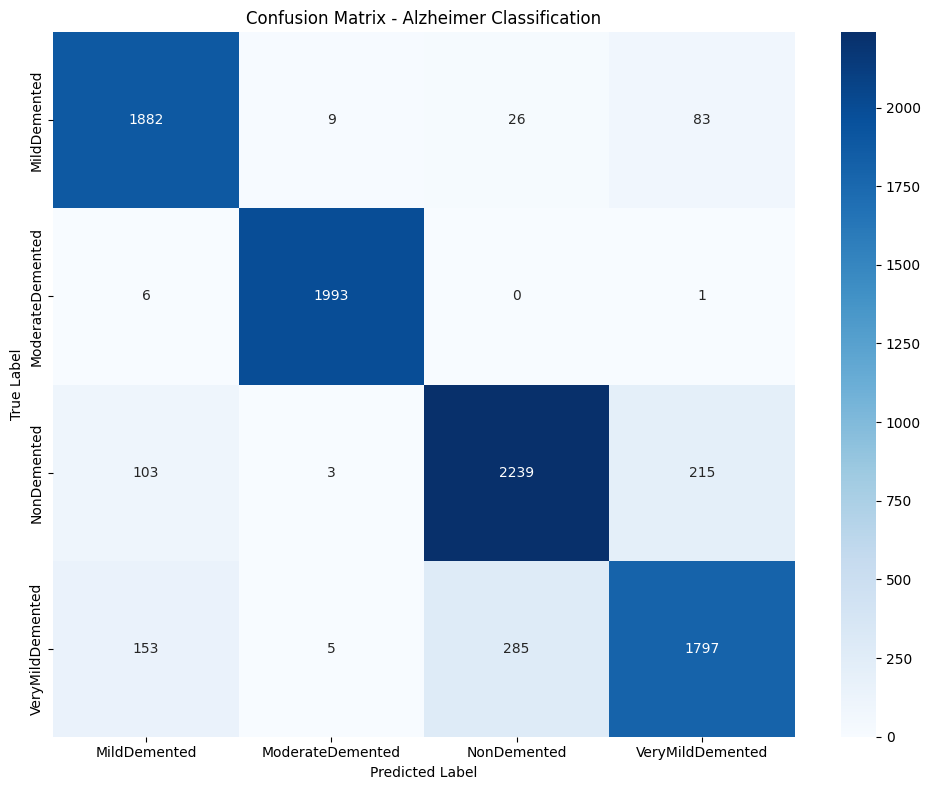

In [20]:
#confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Alzheimer Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

**Saving our final model**

In [21]:
# Save complete model info
torch.save({
    'model_state_dict': final_model.state_dict(),
    'optimizer_state_dict': final_optimizer.state_dict(),
    'val_accuracy': 90.54,
    'hyperparameters': {
        'learning_rate': 0.001,
        'batch_size': 64,
        'dropout': 0.3
    }
}, 'alzheimer_final_model_90.54.pth')